<a href="https://colab.research.google.com/github/JanLeyva/DeepLearning/blob/main/FinalAssignmentV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# downloading data
%%time
%matplotlib inline

import numpy as np
import matplotlib
from matplotlib import pyplot
import os
import time

from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import layers, callbacks, utils, applications, optimizers


CPU times: user 1.76 s, sys: 372 ms, total: 2.13 s
Wall time: 2.42 s


In [6]:
%%time
dropbox = True

if dropbox:
  !wget https://www.dropbox.com/s/svrvpus93131m98/test.csv
  !wget https://www.dropbox.com/s/xzm5f5vrx6jwqui/training.csv
  FTRAIN = 'training.csv'
  FTEST = 'test.csv'
  FLOOKUP = 'IdLookupTable.csv'
else:
  from google.colab import drive
  drive.mount('/content/drive')
  FTRAIN = "/content/drive/MyDrive/dataset/training.csv"
  FTEST = "/content/drive/MyDrive/dataset/test.csv"

--2021-11-06 16:50:15--  https://www.dropbox.com/s/svrvpus93131m98/test.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/svrvpus93131m98/test.csv [following]
--2021-11-06 16:50:15--  https://www.dropbox.com/s/raw/svrvpus93131m98/test.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucded0f39eb03b3f89ba6854826f.dl.dropboxusercontent.com/cd/0/inline/BZeW4YonBP7CHJ828siEjNJjh5UXBOcGM8iBnDp2MR5BC6irc0q8rzjwO2ulFKy8_RmWExVfdMysBb-7xvYAY7celj-07uj852KqtFy8Jkq-j21-j-iIu1HH7tOulMv91cZimb2npsdex_3BoFWTqCMp/file# [following]
--2021-11-06 16:50:15--  https://ucded0f39eb03b3f89ba6854826f.dl.dropboxusercontent.com/cd/0/inline/BZeW4YonBP7CHJ828siEjNJjh5UXBOcGM8iBnDp2MR5BC6irc0q8rzjwO2ulFKy8_RmWExVfdMysBb-7xvYAY7celj-07uj852KqtF

## Import from Kaggle

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from math import sin, cos, pi

from tensorflow.keras.applications import MobileNet
from keras.layers import Conv2D, LeakyReLU, GlobalAveragePooling2D, Dropout, Dense
from keras.models import Sequential

In [8]:
def load(test = False, cols = None):
    """
    Loads the dataset.
    Returns a tuple of X and y, if `test` was set to `True` y contains `None`.    
    """
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]
    print("There are missing points:")
    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        # y = (y - 48) / 48  # scale target coordinates to [-1, 1] // # we will rescale to [-1, 1] later
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X.reshape(df.shape[0],96,96), y

## Plot function

In [9]:
def plot_sample(x, y):
    """
    Plots a single sample image with keypoints on top.   
    """
    pyplot.imshow(x, cmap='gray')
    pyplot.scatter(y[0::2], y[1::2], marker='x', s=10)

There are missing points:
left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_li

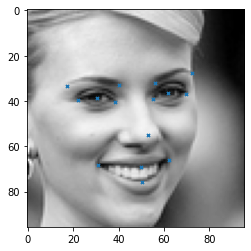

In [10]:
# loading data and checking it

X, y = load()
plot_sample(X[12],y[12])

In [11]:
# Split the initial training dataset into training, validation and testing datasets.

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)
print("Train shape:{}".format(x_train.shape))
print("Test shape:{}".format(x_test.shape))
print("Valid shape:{}".format(x_valid.shape))

Train shape:(1498, 96, 96)
Test shape:(321, 96, 96)
Valid shape:(321, 96, 96)


## WE must reshape the dataset

In [12]:
# Make sure images have shape (28, 28, 1) - Keras requirement!
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_valid = np.expand_dims(x_valid, -1)

In [13]:
def plot_sample(image, keypoint, axis, title):
    image = image.reshape(96,96)
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='x', s=20)
    plt.title(title)

# Data Augmentation
## Rotation

In [14]:
class aug_config:
    rotation_augmentation = True
    brightness_augmentation = True
    shift_augmentation = True
    random_noise_augmentation = True
    rotation_angles = [12]
    pixel_shifts = [12]
    indexPhoto = 100

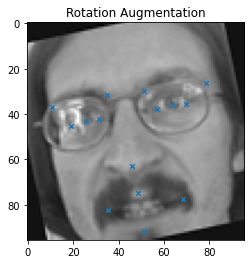

In [15]:
def rotate_augmentation(images, keypoints, rotation_angles):
    rotated_images = []
    rotated_keypoints = []
    for angle in rotation_angles:
        for angle in [angle, -angle]:
            M = cv2.getRotationMatrix2D((48,48), angle, 1.)
            angle_rad = -angle*pi/180.
            for image in images:
                rotated_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                rotated_images.append(rotated_image)
            for keypoint in keypoints:
                rotated_keypoint = keypoint - 48.
                for idx in range(0, len(rotated_keypoint), 2):
                    rotated_keypoint[idx] = rotated_keypoint[idx]*cos(angle_rad)-rotated_keypoint[idx+1]*sin(angle_rad)
                    rotated_keypoint[idx+1] = rotated_keypoint[idx]*sin(angle_rad)+rotated_keypoint[idx+1]*cos(angle_rad)
                rotated_keypoint += 48.   
                rotated_keypoints.append(rotated_keypoint)
            
    return np.reshape(rotated_images,(-1,96,96,1)), rotated_keypoints

if aug_config.rotation_augmentation:
    rotated_train_images, rotated_train_keypoints = rotate_augmentation(x_train, y_train, aug_config.rotation_angles)
    train_images = np.concatenate((x_train, rotated_train_images))
    train_keypoints = np.concatenate((y_train, rotated_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(rotated_train_images[aug_config.indexPhoto], rotated_train_keypoints[aug_config.indexPhoto], axis, "Rotation Augmentation")

In [16]:
print("Shape of training dataset:",train_images.shape)
print("Shape of keypoints dataset:",train_keypoints.shape)

Shape of training dataset: (4494, 96, 96, 1)
Shape of keypoints dataset: (4494, 30)


## Change Brightness¶


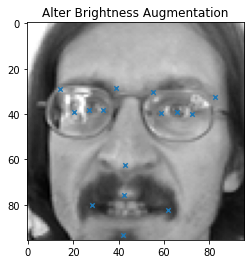

In [17]:
def alter_brightness(images, keypoints):
    altered_brightness_images = []
    inc_brightness_images = np.clip(images*1.2, 0.0, 1.0)    
    dec_brightness_images = np.clip(images*0.6, 0.0, 1.0)    
    altered_brightness_images.extend(inc_brightness_images)
    altered_brightness_images.extend(dec_brightness_images)
    return altered_brightness_images, np.concatenate((keypoints, keypoints))

if aug_config.brightness_augmentation:
    altered_brightness_images, altered_brightness_keypoints = alter_brightness(x_train, y_train)
    train_images = np.concatenate((train_images, altered_brightness_images))
    train_keypoints = np.concatenate((train_keypoints, altered_brightness_keypoints))
    fig, axis = plt.subplots()
    plot_sample(altered_brightness_images[aug_config.indexPhoto], altered_brightness_keypoints[aug_config.indexPhoto], axis, "Alter Brightness Augmentation")

In [18]:
print("Shape of training dataset:",train_images.shape)
print("Shape of keypoints dataset:",train_keypoints.shape)

Shape of training dataset: (7490, 96, 96, 1)
Shape of keypoints dataset: (7490, 30)


## Shift images


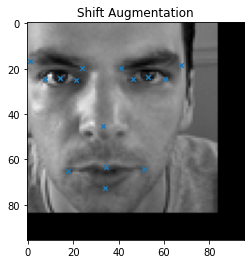

In [19]:
def shift_images(images, keypoints, pixel_shifts):
    shifted_images = []
    shifted_keypoints = []
    for shift in pixel_shifts:    
        for (shift_x,shift_y) in [(-shift,-shift),(-shift,shift),(shift,-shift),(shift,shift)]:
            M = np.float32([[1,0,shift_x],[0,1,shift_y]])
            for image, keypoint in zip(images, keypoints):
                shifted_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                shifted_keypoint = np.array([(point+shift_x) if idx%2==0 else (point+shift_y) for idx, point in enumerate(keypoint)])
                if np.all(0.0<shifted_keypoint) and np.all(shifted_keypoint<96.0):
                    shifted_images.append(shifted_image.reshape(96,96,1))
                    shifted_keypoints.append(shifted_keypoint)
    shifted_keypoints = np.clip(shifted_keypoints,0.0,96.0)
    return shifted_images, shifted_keypoints

if aug_config.shift_augmentation:
    shifted_train_images, shifted_train_keypoints = shift_images(x_train, y_train, aug_config.pixel_shifts)
    train_images = np.concatenate((train_images, shifted_train_images))
    train_keypoints = np.concatenate((train_keypoints, shifted_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(shifted_train_images[aug_config.indexPhoto], shifted_train_keypoints[aug_config.indexPhoto], axis, "Shift Augmentation")

In [20]:
print("Shape of training dataset:",train_images.shape)
print("Shape of keypoints dataset:",train_keypoints.shape)

Shape of training dataset: (11940, 96, 96, 1)
Shape of keypoints dataset: (11940, 30)


## Add noise


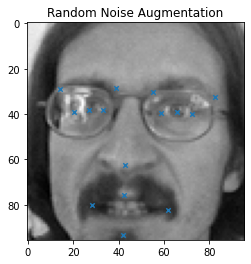

In [21]:
def add_noise(images):
    noisy_images = []
    for image in images:
        noisy_image = cv2.add(image, 0.008*np.random.randn(96,96,1).astype('float32'))    # Adding random normal noise to the input image & clip the resulting noisy image between [-1,1]
        noisy_images.append(noisy_image.reshape(96,96,1))
    return noisy_images

if aug_config.random_noise_augmentation:
    noisy_train_images = add_noise(x_train)
    train_images = np.concatenate((train_images, noisy_train_images))
    train_keypoints = np.concatenate((train_keypoints, y_train))
    fig, axis = plt.subplots()
    plot_sample(noisy_train_images[ aug_config.indexPhoto ], y_train[ aug_config.indexPhoto ], axis, "Random Noise Augmentation")

## All data augmentation

In [ ]:
    print("Rotation Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(rotated_train_images[i], rotated_train_keypoints[i], axis, "")
    plt.show()
    
    print("Brightness Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(altered_brightness_train_images[i], altered_brightness_train_keypoints[i], axis, "")
    plt.show()

    print("Shift Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(shifted_train_images[i], shifted_train_keypoints[i], axis, "")
    plt.show()
    
    print("Random Noise Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(noisy_train_images[i], clean_train_keypoints[i], axis, "")
    plt.show()

In [22]:
print("Shape of training dataset:",x_train.shape)
print("Shape of keypoints dataset:",y_train.shape)

Shape of training dataset: (1498, 96, 96, 1)
Shape of keypoints dataset: (1498, 30)


In [23]:
print("Shape of training dataset:",train_images.shape)
print("Shape of keypoints dataset:",train_keypoints.shape)

Shape of training dataset: (13438, 96, 96, 1)
Shape of keypoints dataset: (13438, 30)


# Model
## WE must reshape the dataset

In [62]:
# Make sure images have shape (28, 28, 1) - Keras requirement!
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_valid = np.expand_dims(x_valid, -1)

### Also we rescale keypoints

In [46]:
y_train = (y_train-48)/48
y_valid = (y_valid-48)/48

In [24]:
train_keypoints = (train_keypoints-48) / 48
y_valid = (y_valid-48)/48

# 2nd Model

In [27]:
model2 = Sequential()
pretrained_model = MobileNet(input_shape=(96,96,3), include_top=False, weights='imagenet')
pretrained_model.trainable = True

model2.add(Conv2D(3, (1,1), padding='same', input_shape=(96,96,1)))
model2.add(LeakyReLU(alpha=0.1))
model2.add(pretrained_model)
model2.add(GlobalAveragePooling2D())
model2.add(Dropout(0.1))
model2.add(Dense(30))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 3)         6         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 96, 3)         0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 3, 3, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                30750     
Total params: 3,259,620
Trainable params: 3,237,732
Non-trainable params: 21,888
_______________________________________

# Training the model + MobileNet

In [28]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlyStopping = EarlyStopping(monitor='loss', patience=30, mode='min',
                             baseline=None)


def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))


# model2.compile(loss=root_mean_squared_error, optimizer="adam")

rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, min_lr=1e-15, mode='min', verbose=1)

model2.compile(optimizer='adam', loss=root_mean_squared_error, metrics=['accuracy'])

history = model2.fit(train_images, train_keypoints, epochs=1, batch_size=64, validation_split=0.1, callbacks=[earlyStopping, rlp])

NameError: ignored

In [113]:
y_new = model2.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square((y_pred*48) - (y_true*48))))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

Mean pixel error:  24.8601


# Model 1st

In [29]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Predefined parameters
input_shape = (96, 96, 1)
output_shape = 30

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(output_shape, activation="linear"),
    ]
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 96, 96, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 36864)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1105950   
Total params: 1,143,518
Trainable params: 1,143,518
Non-trainable params: 0
____________________________________________

In [30]:
batch_size = 128
epochs = 1

from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss=root_mean_squared_error, optimizer="adam")

model.fit(train_images, train_keypoints, batch_size=batch_size, epochs=epochs, validation_split=0.1)

95/95 [==============================] - 39s 91ms/step - loss: 0.1109 - val_loss: 0.0530


In [31]:
y_new = model.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square((y_pred*48) - (y_true*48))))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

Mean pixel error:  2.6136427


# trying again with the rescale after importing

In [48]:
y_new = model.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square((y_pred*48) - (y_true*48))))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

Mean pixel error:  4.086153


# Trying ResNet50

In [32]:
model_ResNet = Sequential()

pretrained_model = tf.keras.applications.ResNet50(input_shape=(96, 96, 3), include_top=False, weights='imagenet')
pretrained_model.trainable = True

model_ResNet.add(layers.Convolution2D(3, (1, 1), padding='same', input_shape=(96,96,1)))
model_ResNet.add(layers.LeakyReLU(alpha = 0.1))
model_ResNet.add(pretrained_model)
model_ResNet.add(layers.GlobalAveragePooling2D())
model_ResNet.add(layers.Dropout(0.1))
model_ResNet.add(layers.Dense(30))
model_ResNet.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 96, 96, 3)         6         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 96, 96, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 30)                61470     
Total params: 23,649,188
Trainable params: 23,596,068
N

In [33]:
train_model = True
print('Training model: ',train_model)

Training model:  True


In [39]:
if train_model:
    es = callbacks.EarlyStopping(
        monitor='loss', patience=30, verbose=1, mode='min', baseline=None, restore_best_weights=True
    )

    rlp = callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=1e-15, mode='min', verbose=1
    )

    model_ResNet.compile(
        optimizer='adam', loss= root_mean_squared_error , metrics=['mae', 'acc']
    )

    history = model_ResNet.fit(
        train_images, train_keypoints, epochs=50, batch_size=batch_size, 
        validation_split=0.1, callbacks=[es, rlp]
    )

Epoch 1/50
95/95 [==============================] - 61s 576ms/step - loss: 0.0327 - mae: 0.0250 - acc: 0.8615 - val_loss: 0.0577 - val_mae: 0.0443 - val_acc: 0.7299
Epoch 2/50
95/95 [==============================] - 54s 566ms/step - loss: 0.0288 - mae: 0.0220 - acc: 0.8752 - val_loss: 0.0452 - val_mae: 0.0336 - val_acc: 0.7969
Epoch 3/50
95/95 [==============================] - 54s 566ms/step - loss: 0.0280 - mae: 0.0214 - acc: 0.8736 - val_loss: 0.0429 - val_mae: 0.0339 - val_acc: 0.8036
Epoch 4/50
95/95 [==============================] - 54s 567ms/step - loss: 0.0273 - mae: 0.0209 - acc: 0.8757 - val_loss: 0.0345 - val_mae: 0.0266 - val_acc: 0.8348
Epoch 5/50
95/95 [==============================] - 55s 575ms/step - loss: 0.0263 - mae: 0.0202 - acc: 0.8818 - val_loss: 0.0431 - val_mae: 0.0346 - val_acc: 0.8274
Epoch 6/50
95/95 [==============================] - 54s 567ms/step - loss: 0.0258 - mae: 0.0198 - acc: 0.8905 - val_loss: 0.0682 - val_mae: 0.0509 - val_acc: 0.6726
Epoch 7/50

In [40]:
y_new_ResNet = model_ResNet.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square((y_pred*48) - (y_true*48))))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new_ResNet))

Mean pixel error:  1.0305785


# Visualize the predictions in Validate data

In [67]:
def plot_sample(x, y, y_true):
    """
    Plots a single sample image with keypoints on top.   
    """
    pyplot.imshow(x, cmap='gray')
    pyplot.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)
    pyplot.scatter(y_true[0::2] * 48 + 48, y_true[1::2] * 48 + 48, marker='o', s=10)


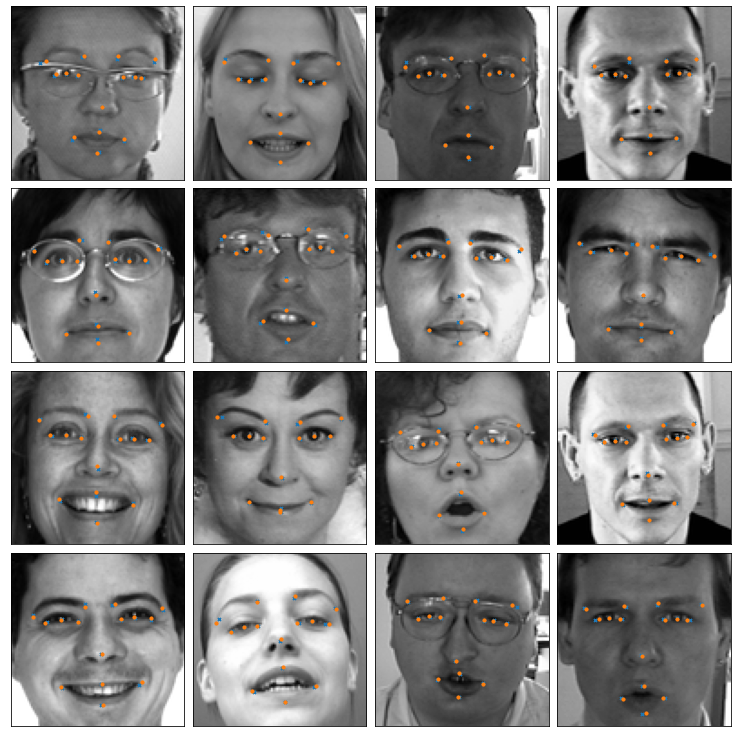

In [68]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_new_ResNet[i], y_valid[i])

pyplot.show()

### Save the model

##### We build a custom object in order to save our model

In [49]:
# Retrieve the config
config = model_ResNet.get_config()

# custom loss function
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))


# At loading time, register the custom objects with a `custom_object_scope`:
custom_objects = {"custom_loss": root_mean_squared_error}
with keras.utils.custom_object_scope(custom_objects):
  new_model = keras.Model.from_config(config)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


KeyError: ignored

In [41]:
!mkdir -p saved_model
model_ResNet.save('saved_model/my_model_ResNet') 

INFO:tensorflow:Assets written to: saved_model/my_model_ResNet/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [44]:
model_ResNet.save("my_h5_model.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [45]:
!ls

my_h5_model.h5	sample_data  saved_model  test.csv  training.csv


### If we want load our ResNet model

In [52]:
# reconstructed_model = keras.models.load_model("my_h5_model.h5")

loaded_1 = keras.models.load_model(
    "my_h5_model.h5", custom_objects={"custom_loss": root_mean_squared_error}
)

ValueError: ignored

In [51]:
!ls

my_h5_model.h5	sample_data  saved_model  test.csv  training.csv


In [42]:
new_model = tf.keras.models.load_model('saved_model/my_model_ResNet')

ValueError: ignored

In [ ]:
y_new_newmodel = new_model.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square((y_pred*48) - (y_true*48))))

print("Mean pixel error: ", rmse_pixel(y_new_newmodel, y_new_ResNet))